# Wasserstein Generative Adversarial Networks with PyTorch

#### *Nicolas Courty, Rémi Flamary*

In this tutorial, we will see how to use the Wasserstein distance in the process of learning a Generative Adversarial Network (GAN). GAN are powerful objects that provide means of generating new samples from complex, high-dimensional distributions $P_r$ (such as collection of images) by learning a generative network $g_\theta$, parametrized by $\theta$, that takes a low-dimensional noise (let's say $d$ dimensional) as input. As such, $P_\theta = g_\theta(Z)$, $Z \sim \mathcal{N}({\bf 0}_d, {\bf I}_{d\times d})$ should match as close as possible $P_r$.

There exists several ways to train this generator. In a nutshell, the basic idea is to align the distribution of generated samples to the distribution that we want to match.

In a seminal work, Goodfellow [1] proposed to learn a generator that produces samples that are undistinguishable from the input distribution sample up to a classifier that tries to distinguish them. This leads to an adversarial approach , where both the generator and the classifier work in competition.

Another class of approach considers minimizing a divergence $\delta$ between $P_r$ and $P_\theta$ as a loss function for training $g_\theta$. Several options exist for $\delta$, for example:
* Total Variation, $\delta(P_r,P_\theta) = \sup_{A} | P_r(A) - P_\theta(A) |$
* Kullback-Leibler (KL) divergence, $\delta(P_r,P_\theta) = KL(P_r\|P_\theta) = \int_x \log\left(\frac{P_r(x)}{P_\theta(x)}\right) P_r(x) \,dx$

Arjovsky and colleagues [2] proposed to use the Wasserstein 1 distance in this context. We have here:
$$ \delta(P_r,P_\theta) = W_1(P_r,P_\theta) = \inf_{\gamma \in \Pi(P_r ,P_\theta)} \mathbb{E}_{(x, y) \sim \gamma}\big[\:\|x - y\|\:\big] $$

There are several nice properties associated with this:
* the resulting model is very easy to implement and simple;
* the gradients of $W_1$ are practically never 0, which can be the case with Total Variation or KL divergence, especially when the supports of $P_r$ and $P_\theta$ do not overlap.

However, computing $W_1$ requires to compute a coupling $\gamma$ which is infeasible for large datasets. Instead, relying on the Kantorovich-Rubinstein duality, one can instead consider the dual formulation of $W_1$:
$$W(P_r, P_\theta) = \sup_{\|f\|_L \leq 1} \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_\theta}[f(x)]$$
where the supremum is taken over all 1-Lipschitz functions.

We are going to explore, how in a task of generating a simple 2D toy distribution, how to implement such a generative adversarial network. 

#### Ref. 
[1] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014. Generative adversarial nets. In Proceedings of the 27th International Conference on Neural Information Processing Systems - Volume 2 (NIPS'14), Vol. 2. MIT Press, Cambridge, MA, USA, 2672-2680. 

[2]  Martin Arjovsky, Soumith Chintala, Léon Bottou. 2017, Wasserstein Generative Adversarial Networks. Proceedings of the 34th International Conference on Machine Learning, PMLR 70:214-223, 2017

The paper can be found here http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf

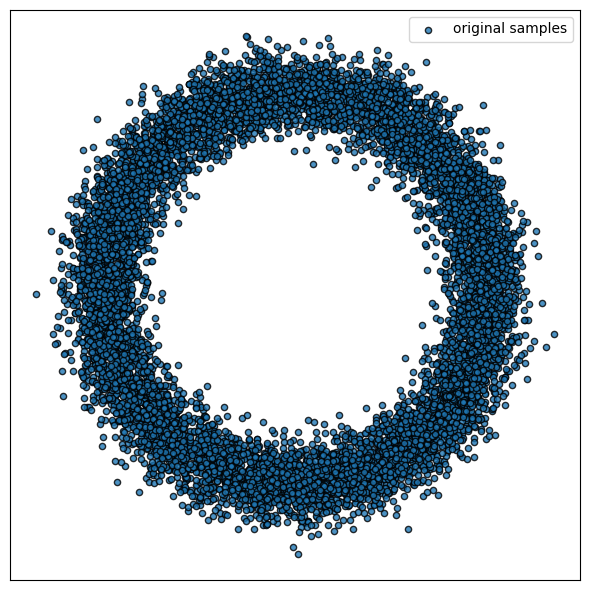

In [46]:
import numpy as np
import matplotlib.pyplot as pl

nb_samples = 10000

radius = 1

nz = .1

X_train = np.zeros((nb_samples,2))
r = np.random.normal(radius,nz,nb_samples)
theta=np.random.rand(nb_samples)*2*np.pi
X_train[:,0]=r*np.cos(theta)
X_train[:,1]=r*np.sin(theta)



pl.figure(figsize=(6,6))
pl.scatter(X_train[:,0], X_train[:,1],s = 20, alpha=0.8, edgecolor = 'k', marker = 'o',label='original samples') 
pl.xticks([], [])
pl.yticks([], [])
pl.legend(loc='best')
pl.tight_layout()
pl.show()

#### PyTorch implementation of WGAN

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
X_train = torch.Tensor(X_train).to(device)

We will start by creating our generator $g_\theta(Z)$. It consists in a neural network that will take a d-dimensional noise vector and produce a sample in 2D.

I suggest the following 2-layers architecture, where the non-linearity is produced by using the ReLu activation. The final layer has Linear activations, so that the 2D coordinates can be arbitrarly positive or/and negative.

In [49]:
class Generator(nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU(),
                                 nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        return self.net(x)

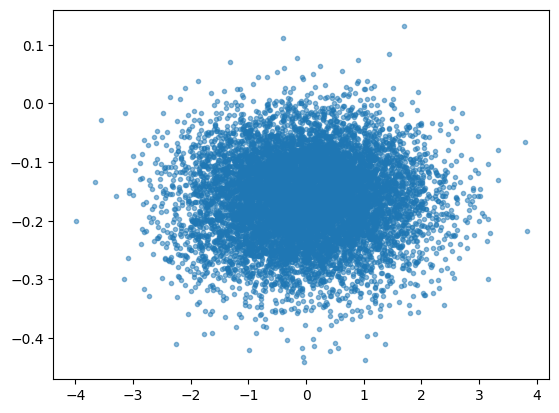

In [50]:
gen = Generator()
gen.to(device)
x = torch.randn((10000, 100)).to(device)
y = gen(x).detach().cpu().numpy()
x = x.to("cpu")
pl.plot(x[:, 0], y[:, 1], ".", alpha=0.5)

The second step is a network, usually called *discriminator* in the literature, that is the dual function $f()$ in the previous definition (Kantorovich potential). This function, as a potential function, outputs a scalar value.

Please note that this is where the first approximation comes into play. Because $f()$ belongs to a particular class of parametrized neural network, we are not any more optimizing over the set of all 1-Lipschitz functions.

In [51]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU(),
                                 nn.Linear(64, 1), nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

We recall here that we want to miminize the Wasserstein distance between the nominal distribution $P_r$ and the generated distribution $P_\theta$. This leads to the following optimization problem:
$$ \min_\theta W_1(P_r,P_\theta) = \min_\theta \sup_{f, ||f||_L=1} \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{z \sim \mathcal{N}}[f(g_\theta(z))]$$
In order to find $g_\theta()$, this bi-level optimization problem has to be solved. Generally, one first optimizes over $f()$ with a fixed generator, and, after fixing $f()$, simply maximizes   $\mathbb{E}_{z \sim \mathcal{N}}[f(g_\theta(z))]$ by backpropagating the gradient of $f()$ in $g_\theta$.

We will first express the two expectations as a simple loss function that simply computes the expectations of $f()$ over $P_r$ and over $P_\theta$.
In order to take into account the plus and minus signs inside, we simply use a scalar product with a vector of ones or minus ones.
Write this corresponding loss function. 


In [52]:
class WassersteinLoss(nn.Module):
    def forward(self, y_true, y_pred):
        return torch.mean(y_true) - torch.mean(y_pred)

If we replace the supremum over 1-Lipschitz functions
with the supremum over K-Lipschitz functions, then the supremum is $K \cdot W(P_r, P_\theta)$ instead (This is true because every K-Lipschitz
function is a 1-Lipschitz function if you divide it by $K$, and the Wasserstein objective is linear).

The supremum over K-Lipschitz functions $\{f : \|f\|_L \le K\}$ is still intractable, but now it’s easier to approximate.
Suppose we have a parametrized function family $\{f_w\}_{w \in \mathcal{W}}$,
where $w$ are the weights and $\mathcal{W}$ is the set of all possible weights. Further suppose these functions are all
K-Lipschitz for some $K$. Then we have

$$\begin{aligned}
    \max_{w \in \mathcal{W}}
        \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{x \sim P_\theta}[f_w(x)]
    &\le \sup_{\|f\|_L \le K}
        \mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_\theta}[f(x)] \\
    &= K \cdot W(P_r, P_\theta)
\end{aligned}$$

Actually we only care about the gradients of $ W(P_r, P_\theta)$, so adding multiplying it by a constant $K$ does not change anything. To guarantee that 
$f_w$ is K-Lipschitz, the original WGAN paper proposes to use weight clipping. The weights $w$ are constrained to lie within $[-c, c]$,
by clipping $w$ after every update to $w$. 

Write a function that actually performs this clipping.

In [53]:
def clip(f, c):
    for p in f.parameters():
        p.data = torch.clamp(p.data, -c, c)
        
noise_dim = 2

In [54]:
def generate_images(generator_model, noise_dim, num_samples=1000):
    noise = torch.randn(num_samples, noise_dim).to(device)
    predicted_samples = generator_model(noise).detach().cpu().numpy()
    pl.figure(figsize=(6,6))
    pl.scatter(X_train[:,0].detach().cpu().numpy(), X_train[:,1].detach().cpu().numpy(),s = 40, alpha=0.2, edgecolor = 'k', marker = '+',label='original samples') 
    pl.scatter(predicted_samples[:,0], predicted_samples[:,1],s = 10, alpha=0.9,c='r', edgecolor = 'k', marker = 'o',label='predicted') 
    pl.xticks([], [])
    pl.yticks([], [])
    pl.legend(loc='best')
    pl.tight_layout()    
    pl.show()

In [55]:
def trainWGAN(generator, discriminator, optimizer, c, lr=1e-3, epochs=20, batch_size=64, n_crit=5, device=device):
    generator.to(device)
    discriminator.to(device)
    gen_optim = optimizer(generator.parameters(), lr=lr)
    disc_optim = optimizer(discriminator.parameters(), lr=lr)
    wasserstein_loss = WassersteinLoss()
    
    for epoch in range(epochs):    
        if epoch%50==0:
            print("Epoch: ", epoch)
            with torch.no_grad():
                generate_images(generator, noise_dim)
        
        for i in range(0, len(X_train), batch_size):        
            real_x = X_train[i:i+batch_size].to(device)
            
            #Discriminator:
            disc_optim.zero_grad()

            z = torch.randn(batch_size, noise_dim).to(device)
            fake_x = generator(z).detach()
            
            d_real = discriminator(real_x)
            d_fake = discriminator(fake_x)

            loss = -wasserstein_loss(d_real, d_fake)
            loss.backward()
            disc_optim.step()
            clip(discriminator, c)

            if i % n_crit == 0:
                gen_optim.zero_grad()
                
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_x = generator(z)
            
                loss = -torch.mean(discriminator(fake_x))
                
                loss.backward()
                gen_optim.step()

Epoch:  0


/tmp/ipykernel_855835/3013377326.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(X_train[:,0].detach().cpu().numpy(), X_train[:,1].detach().cpu().numpy(),s = 40, alpha=0.2, edgecolor = 'k', marker = '+',label='original samples')


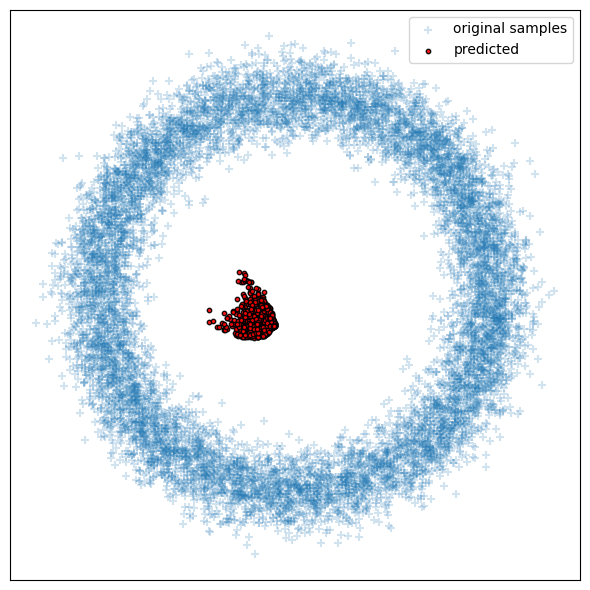

Epoch:  50


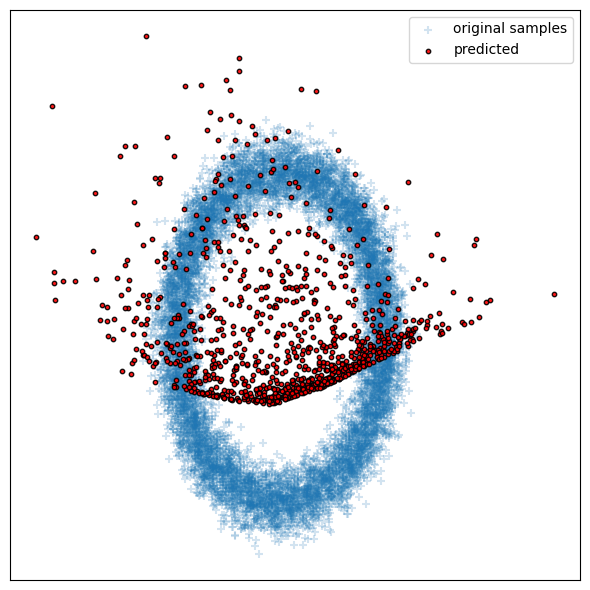

Epoch:  100


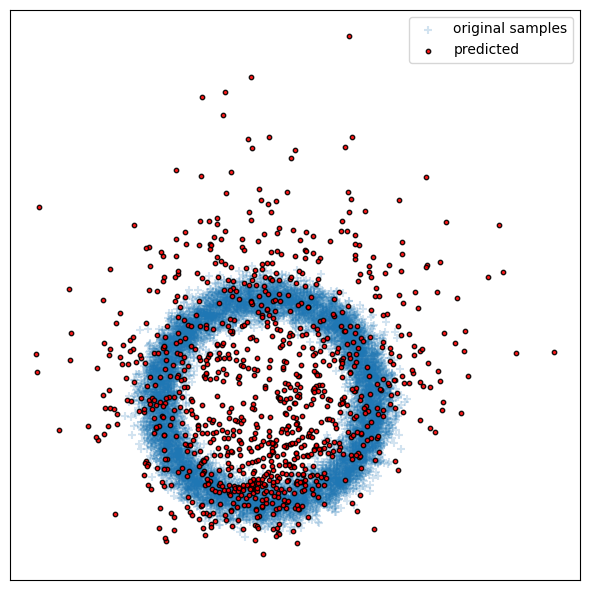

Epoch:  150


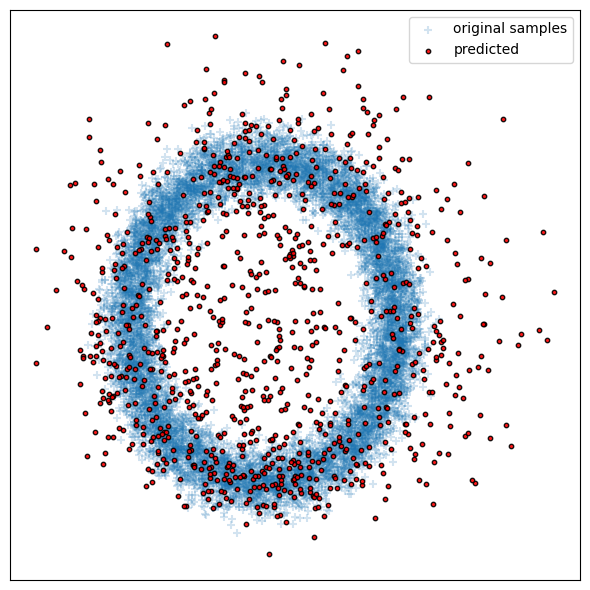

Epoch:  200


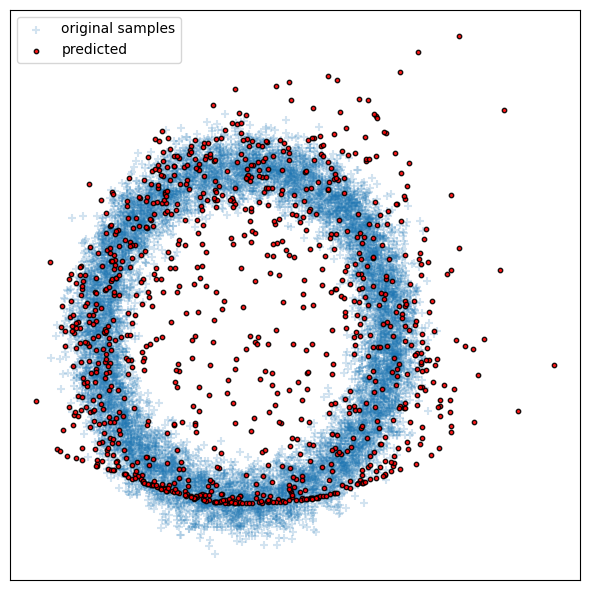

Epoch:  250


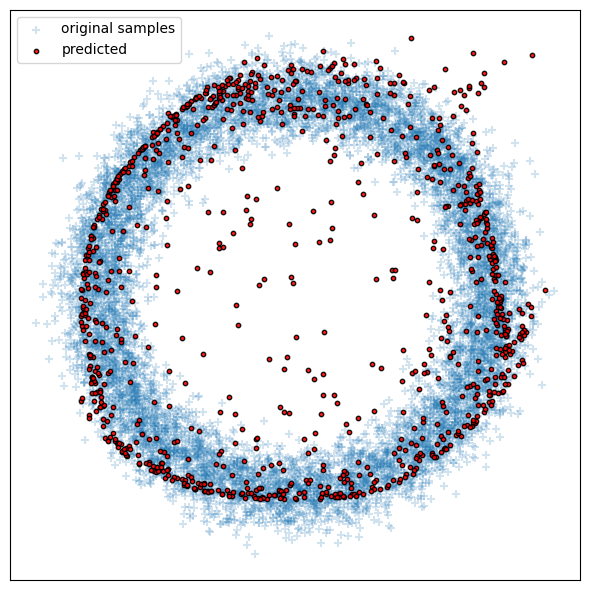

Epoch:  300


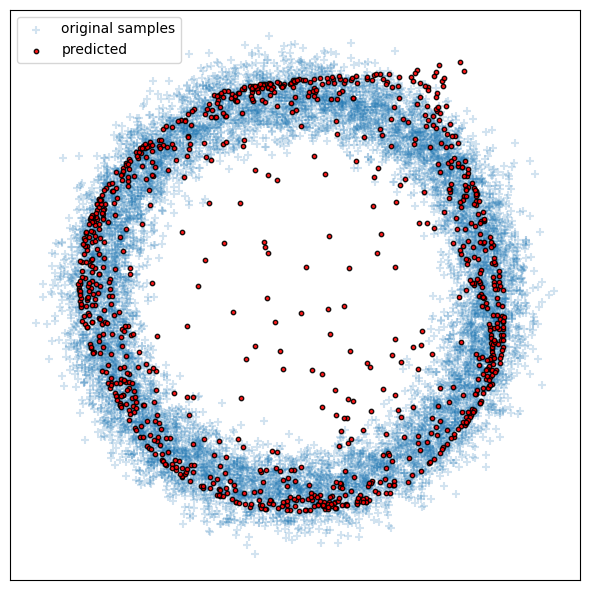

Epoch:  350


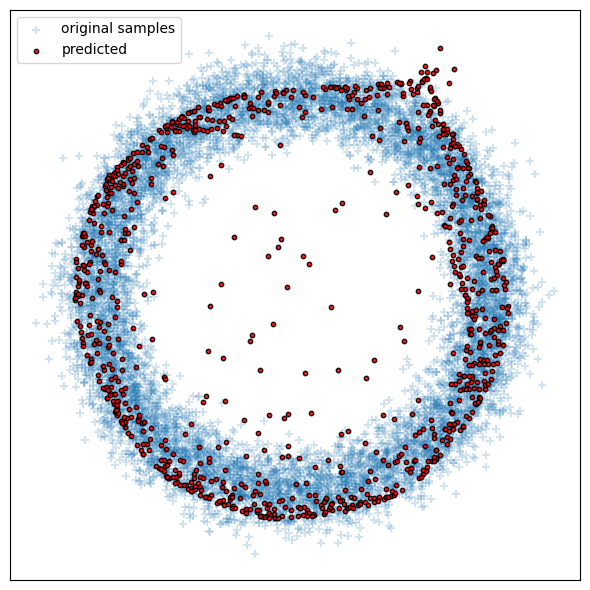

Epoch:  400


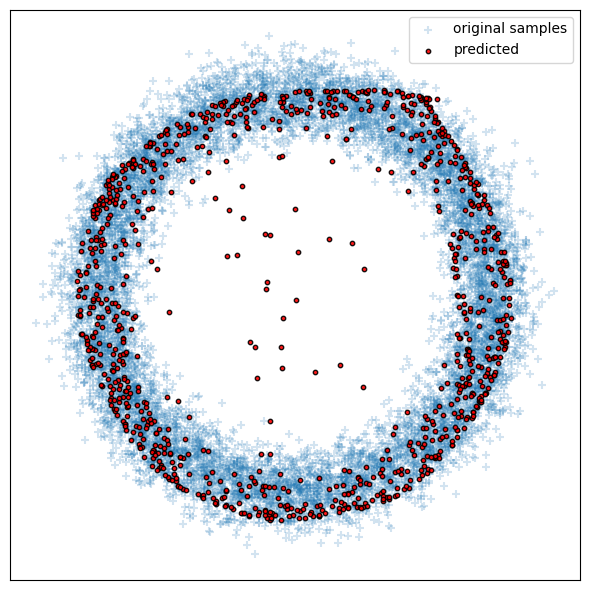

Epoch:  450


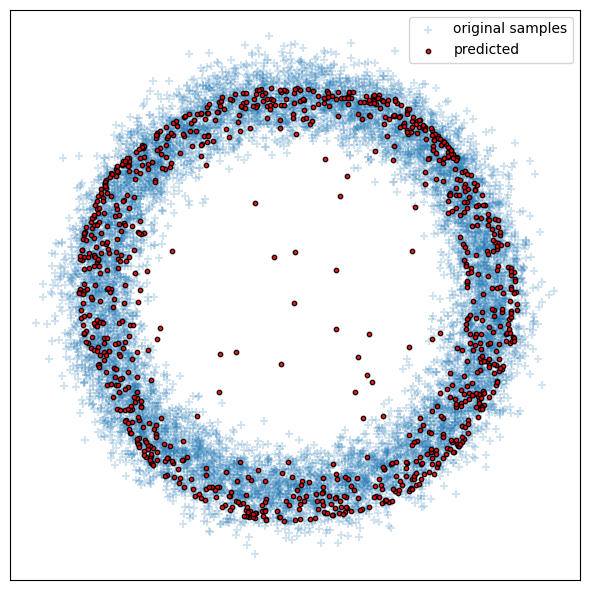

In [16]:
optimizer = optim.RMSprop
noise_dim = 2
generator = Generator(input_size=noise_dim).to(device)
discriminator = Discriminator().to(device)
trainWGAN(generator, discriminator, optimizer, 0.01, lr=1e-5, epochs=500, device=device)

## Gradient penalty

Achieving the K-Lipschitz condition with weight clipping is a trick that might suffer from some drawbacks, such as poor convergence or poor quality of generated samples, mostly because of underuse of the capacity of the network. In [3], Gulrajani and colleagues proposed a different way of achieving the Lipschitz constraint of $f$ by constraining the norm of the gradient of $f$ to be $1$. The corresponding approximation then reads:

$$ \min_\theta W_1(P_r,P_\theta) \approx \min_\theta \max_w \mathbb{E}_{x \sim P_r}[f_w(x)] - \mathbb{E}_{z \sim \mathcal{N}}[f_w(g_\theta(z))] + \lambda \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} [||\nabla_{\hat{x}} f(\hat{x})||_2 - 1)^2]$$

$P_{\hat{x}}$ is defined implicitly by sampling uniformly along straight lines between pairs of points sampled from the data distribution $P_r$ and the generator distribution $P_\theta$. Practically, this means that we will have to:
- Construct weighted averages between $(x_1 \sim P_r)$ and $(x_2 \sim P_\theta)$ such that $(\hat{x} = (1-\epsilon)x_1 + \epsilon x_2)$ with $\epsilon \sim \mathcal{U}(0,1)$;
- Evaluate the gradient of $f$ on those points;
- Define a new loss that constrains this gradient to be close to 1 when learning for $f$.


[3] Gulrajani, Ishaan & Ahmed, Faruk & Arjovsky, Martin & Dumoulin, Vincent & Courville, Aaron. (2017). Improved Training of Wasserstein GANs. 
https://arxiv.org/pdf/1704.00028.pdf

In [56]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples, lambda_reg):
    dummy = torch.ones_like(y_pred, requires_grad=True)
    
    gradients = torch.autograd.grad(outputs=y_pred, inputs=averaged_samples, grad_outputs=dummy, create_graph=True, retain_graph=True, allow_unused=True)[0]
    
    # Check if gradients are not None
    if gradients is not None:
        # Compute the gradient penalty term
        gradient_penalty = lambda_reg * ((gradients.norm(2, dim=1) - 1)**2).mean()

        # Return the final gradient penalty loss
        return torch.mean(y_true) - torch.mean(y_pred) + gradient_penalty
    else:
        # Return some default value or handle the case when gradients are None
        return torch.mean(y_true) - torch.mean(y_pred)


In [57]:
def trainWGAN_gradientPenalty(generator, discriminator, optimizer = optim.Adam, lr=1e-3, epochs=20, batch_size=64, n_crit=5, device=device, beta1=0, beta2=0.9, lambda_reg=10):
    generator.to(device)
    discriminator.to(device)
    gen_optim = optimizer(generator.parameters(), lr=lr, betas=(beta1, beta2))
    disc_optim = optimizer(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    
    for epoch in range(epochs):    
        if epoch%50==0:
            print("Epoch: ", epoch)
            with torch.no_grad():
                generate_images(generator, noise_dim)
        
        for i in range(0, len(X_train), batch_size):        
            real_x = X_train[i:i+batch_size].to(device)
            
            #Discriminator:
            disc_optim.zero_grad()
            bs = real_x.shape[0]
            z = torch.randn(bs, noise_dim).to(device)
            fake_x = generator(z).detach()
            
            d_real = discriminator(real_x)
            d_fake = discriminator(fake_x)

            eps = torch.rand(1).to(device)
            averaged_samples = eps * real_x + (1 - eps) * fake_x
            averaged_samples.requires_grad_(True)
            loss = - gradient_penalty_loss(d_real, d_fake, averaged_samples, lambda_reg)
            loss.backward()
            disc_optim.step()

            if i % n_crit == 0:
                gen_optim.zero_grad()
                
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_x = generator(z)
            
                loss = -torch.mean(discriminator(fake_x))
                
                loss.backward()
                gen_optim.step()

Epoch:  0


/tmp/ipykernel_855835/3013377326.py:5: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(X_train[:,0].detach().cpu().numpy(), X_train[:,1].detach().cpu().numpy(),s = 40, alpha=0.2, edgecolor = 'k', marker = '+',label='original samples')


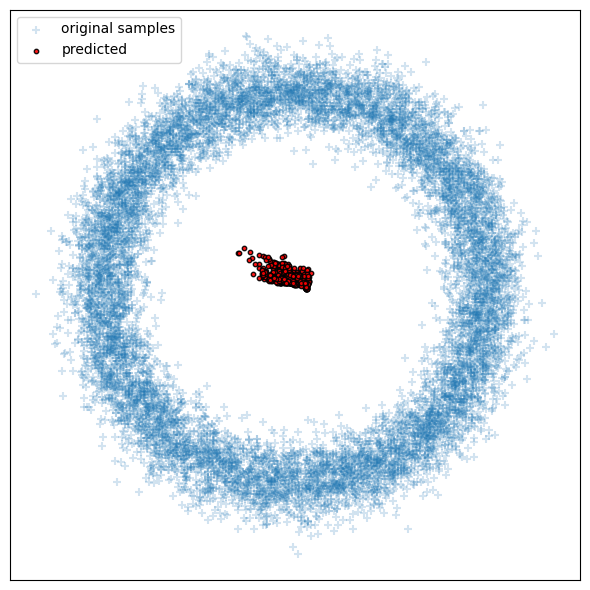

Epoch:  50


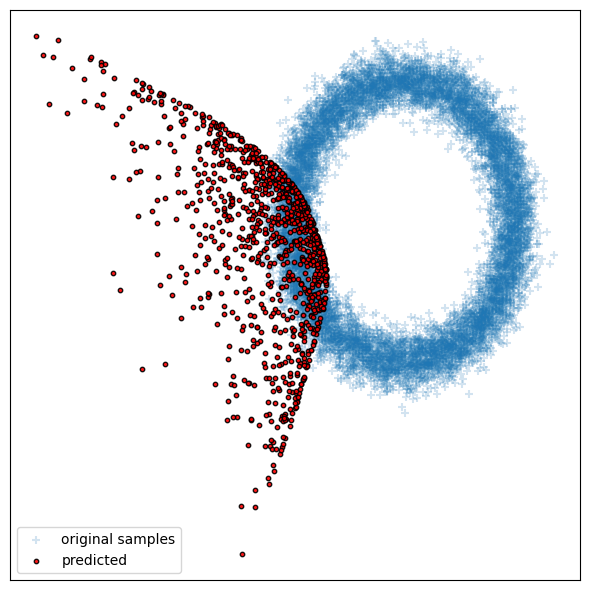

Epoch:  100


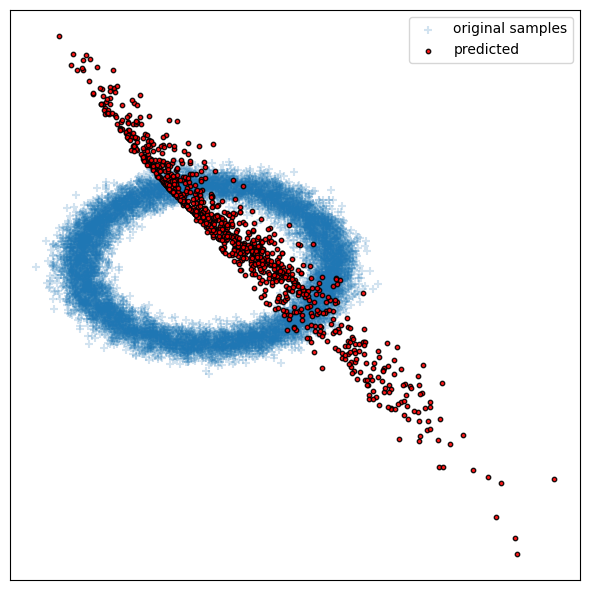

Epoch:  150


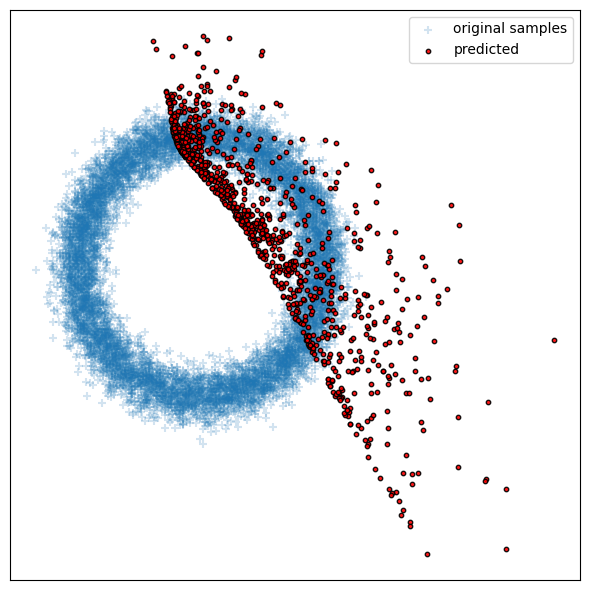

Epoch:  200


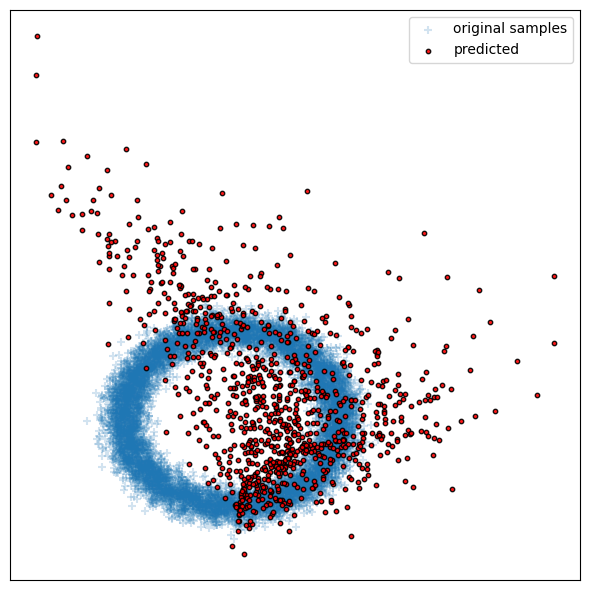

Epoch:  250


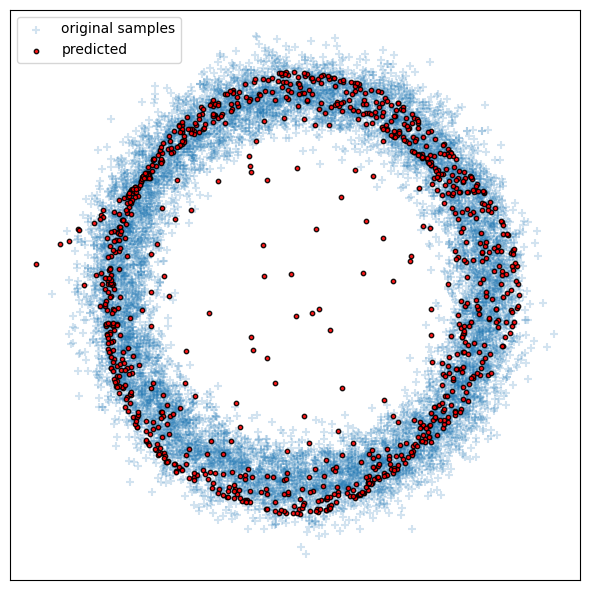

Epoch:  300


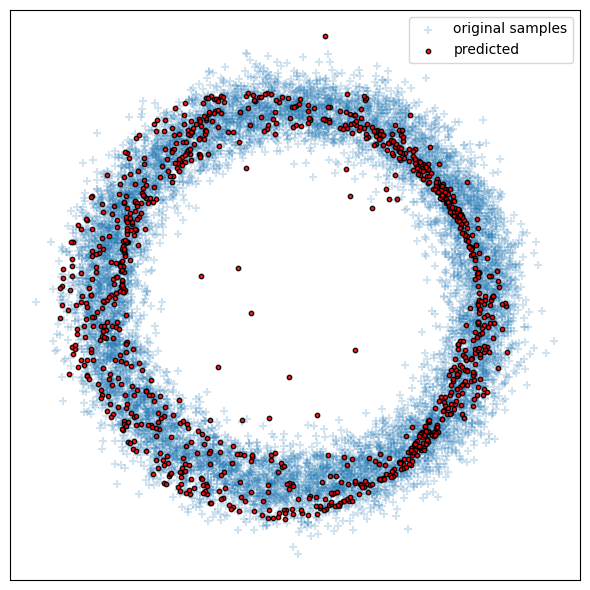

Epoch:  350


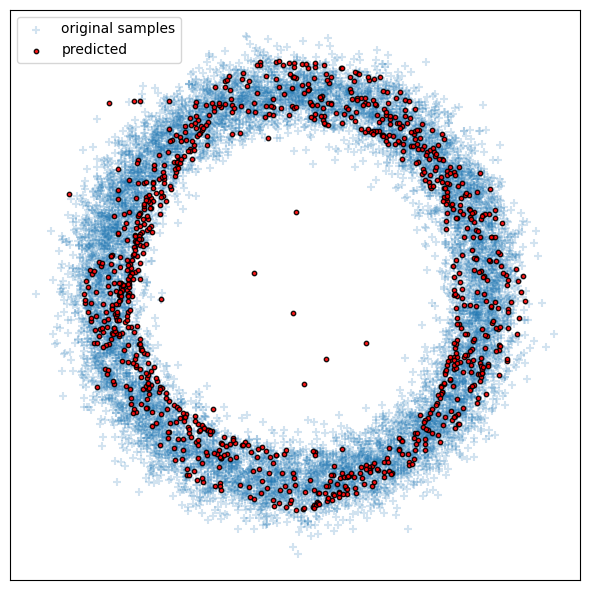

Epoch:  400


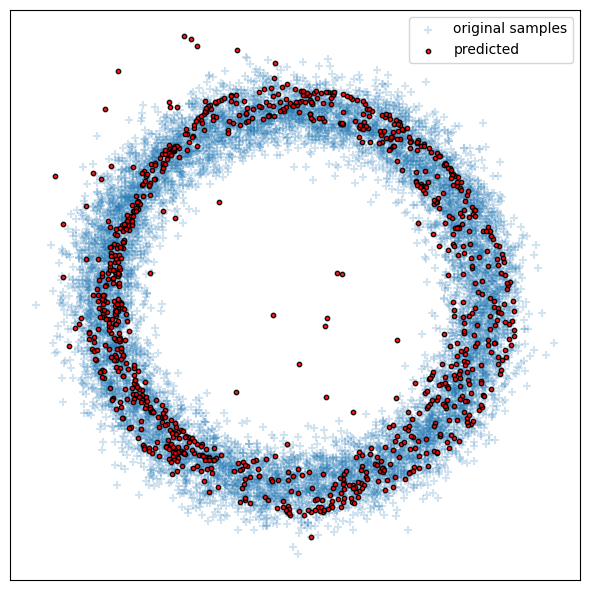

Epoch:  450


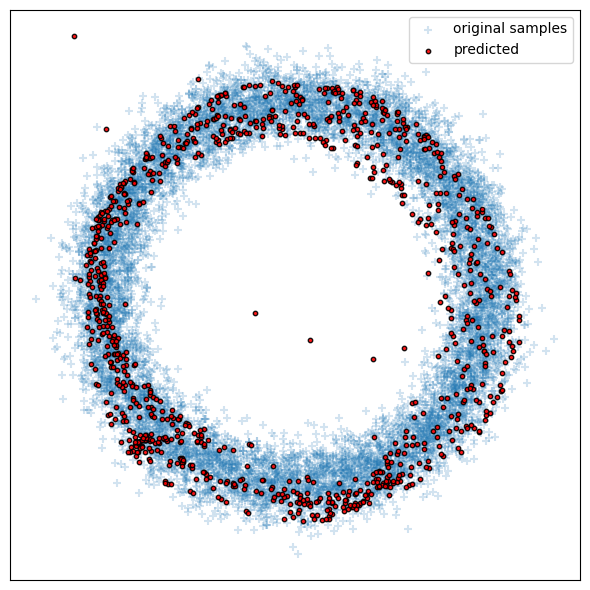

In [58]:
optimizer = optim.Adam
noise_dim = 2
generator = Generator(input_size=noise_dim).to(device)
discriminator = Discriminator().to(device)
trainWGAN_gradientPenalty(generator, discriminator, lr=1e-4, epochs=500, lambda_reg=1.5, beta1=0.5, beta2=0.9)